<a href="https://colab.research.google.com/github/jyotikashyap85399-tech/Image-classification/blob/main/NLP_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from gensim import corpora
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.3 MB/s eta 0:00:00


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/yelp_reviews_subset_2.csv')

In [5]:
df.head()

,Unnamed: 0,Text,Labels
0,0,My expectations for McDonalds are t rarely hig...,0
1,1,I've tried to give this McDonalds a chance but...,0
2,2,This McDonald's is so bad it's amazing. \n\nO...,0
3,3,We had the worst possible experience at the Ea...,0
4,4,They burned my fish and they burned it bad. O...,2


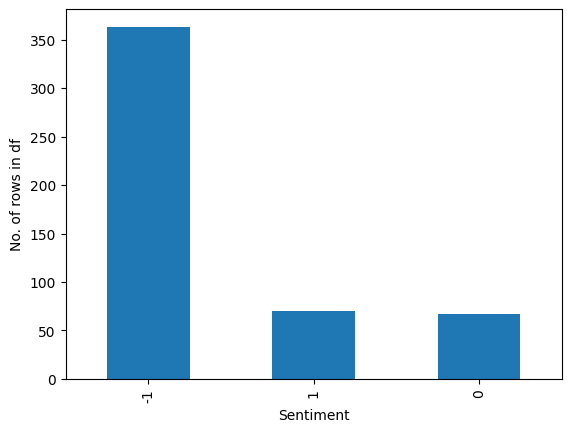

In [6]:
def map_sentiment(stars_received):
    if stars_received <= 2:
        return -1
    elif stars_received == 3:
        return 0
    else:
        return 1

df['sentiment'] = df['Labels'].apply(map_sentiment)
df['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentiment')
plt.ylabel('No. of rows in df')
plt.show()

In [9]:
#tokenize and stem
df['tokenized_text'] = df['Text'].apply(lambda x: word_tokenize(str(x).lower()))
ps = PorterStemmer()
df['stemmed_tokens'] = df['tokenized_text'].apply(lambda tokens: [ps.stem(w) for w in tokens])
df[['tokenized_text','stemmed_tokens']].head(10)

,tokenized_text,stemmed_tokens
0,"[my, expectations, for, mcdonalds, are, t, rar...","[my, expect, for, mcdonald, are, t, rare, high..."
1,"[i, 've, tried, to, give, this, mcdonalds, a, ...","[i, 've, tri, to, give, thi, mcdonald, a, chan..."
2,"[this, mcdonald, 's, is, so, bad, it, 's, amaz...","[thi, mcdonald, 's, is, so, bad, it, 's, amaz,..."
3,"[we, had, the, worst, possible, experience, at...","[we, had, the, worst, possibl, experi, at, the..."
4,"[they, burned, my, fish, and, they, burned, it...","[they, burn, my, fish, and, they, burn, it, ba..."
5,"[some, how, even, though, the, food, at, this,...","[some, how, even, though, the, food, at, thi, ..."
6,"[mmm, ..., peppermint, mocha\n\nin, my, quest,...","[mmm, ..., peppermint, mocha\n\nin, my, quest,..."
7,"[if, there, was, ever, a, \, '', get, your, co...","[if, there, wa, ever, a, \, '', get, your, cof..."
8,"[i, just, realized, they, remodeled, this, one...","[i, just, realiz, they, remodel, thi, one, rec..."
9,"[great, location, !, close, to, shops, and, th...","[great, locat, !, close, to, shop, and, theatr..."


In [23]:
#split train_test
X_train, X_test, Y_train, Y_test = train_test_split(
    df[['tokenized_text','stemmed_tokens']], df['sentiment'], test_size=0.3, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
print(X_train.head())

                                      tokenized_text                                     stemmed_tokens
0  [some, how, even, though, the, food, at, this,...  [some, how, even, though, the, food, at, thi, ...
1  [i, 've, always, been, pleasantly, surprised, ...  [i, 've, alway, been, pleasantli, surpris, wit...
2  [even, when, we, did, n't, have, a, car, filen...  [even, when, we, did, n't, have, a, car, filen...
3  [the, one, good, thing, i, can, say, about, mi...  [the, one, good, thing, i, can, say, about, mi...
4  [went, here, with, a, friend, for, his, haircu...  [went, here, with, a, friend, for, hi, haircut...


In [11]:
#set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running:",device)

Device available for running: cpu


In [12]:
#device feedforward neural network
class FeedForwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_dim):
        super(FeedForwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim,hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return F.softmax(out, dim=1)

In [13]:
#create dictionary using Gensim
def make_dict(top_data_df_small, padding=True):
    if padding:
        review_dict = corpora.Dictionary([['pad']])
        review_dict.add_documents(top_data_df_small['stemmed_tokens'])
    else:
        review_dict = corpora.Dictionary(top_data_df_small['stemmed_tokens'])
    return review_dict

review_dict = make_dict(df, padding=False)

In [19]:
#make BoW vector and target tensor

VOCAB_SIZE = len(review_dict)
NUM_LABELS = 3

def make_bow_vector(review_dict, sentence):
    vec = torch.zeros(VOCAB_SIZE, dtype=torch.float6, device=device)
    for word in sentence:
        if word in review_dict.token2id:
            vec[review_dict.token2id[word]] += 1
        return vec.view(1, -1).float()

def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype = torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype = torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [20]:
#initialize model,loss,optimizer
input_dim = VOCAB_SIZE
hidden_dim = 100
output_dim = 3
num_epochs = 100

ff_nn_bow_model = FeedForwardNeuralNetModel(input_dim,hidden_dim, output_dim).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(ff_nn_bow_model.parameters(), lr=1e-3)

In [21]:
#Training loop without dropout
ffnn_loss_file_name = 'ffnn_bow_loss.csv'
f = open(ffnn_loss_file_name,'w')
f.write('iter, loss\n')

for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed:", epoch+1)
    train_loss = 0
    for index, row in X_train.iterrows():
        optimizer.zero_grad()
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        target = make_target(Y_train[index])
        loss = loss_function(probs, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    f.write(f"{epoch+1},{train_loss / len(X_train)}\n")
f.close()


Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


              precision    recall  f1-score   support

           0       0.71      1.00      0.83       106
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        20

    accuracy                           0.71       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.50      0.71      0.59       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


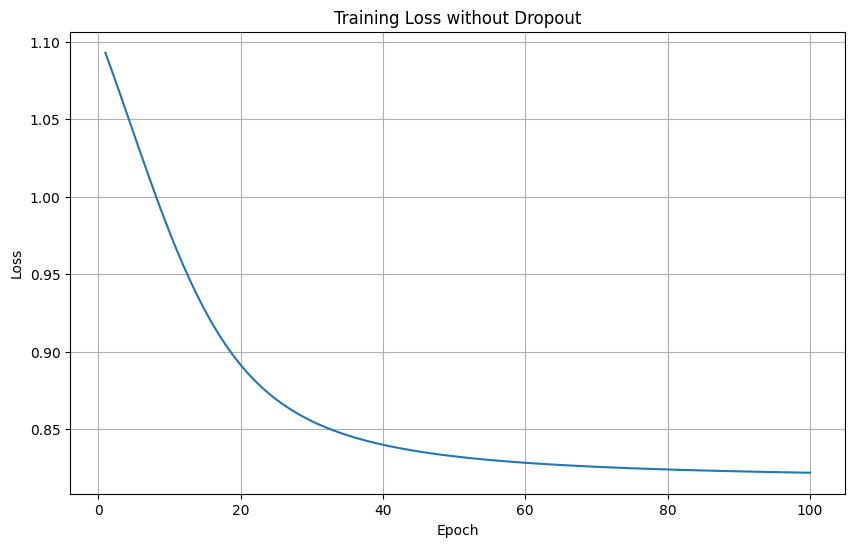

In [24]:
#Evaluate on test set
bow_ff_nn_predictions = []
original_labels_ff_bow = []

ff_nn_bow_model.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model(bow_vec)
        bow_ff_nn_predictions.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_labels_ff_bow.append(make_target(Y_test[index]).cpu().numpy()[0])

print(classification_report(original_labels_ff_bow, bow_ff_nn_predictions))

# Plot loss
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
plt.figure(figsize=(10,6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss without Dropout')
plt.grid(True)
plt.show()


In [25]:
#Model with Dropout
class FeedforwardNeuralNetModelDropout(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(FeedforwardNeuralNetModelDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return F.softmax(out, dim=1)

ff_nn_bow_model_dropout = FeedforwardNeuralNetModelDropout(input_dim, hidden_dim, output_dim, dropout_rate=0.5).to(device)
loss_function_dropout = nn.CrossEntropyLoss()
optimizer_dropout = optim.SGD(ff_nn_bow_model_dropout.parameters(), lr=1e-3)

# Training loop with dropout
ffnn_loss_file_name_dropout = 'ffnn_bow_loss_dropout.csv'
f_dropout = open(ffnn_loss_file_name_dropout, 'w')
f_dropout.write('iter, loss\n')

ff_nn_bow_model_dropout.train()
for epoch in range(num_epochs):
    if (epoch+1) % 25 == 0:
        print("Epoch completed:", epoch+1)
    train_loss_dropout = 0
    for index, row in X_train.iterrows():
        optimizer_dropout.zero_grad()
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        target = make_target(Y_train[index])
        loss = loss_function_dropout(probs, target)
        train_loss_dropout += loss.item()
        loss.backward()
        optimizer_dropout.step()
    f_dropout.write(f"{epoch+1},{train_loss_dropout / len(X_train)}\n")
f_dropout.close()


Epoch completed: 25
Epoch completed: 50
Epoch completed: 75
Epoch completed: 100


Classification Report with Dropout:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       106
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        20

    accuracy                           0.71       150
   macro avg       0.24      0.33      0.28       150
weighted avg       0.50      0.71      0.59       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


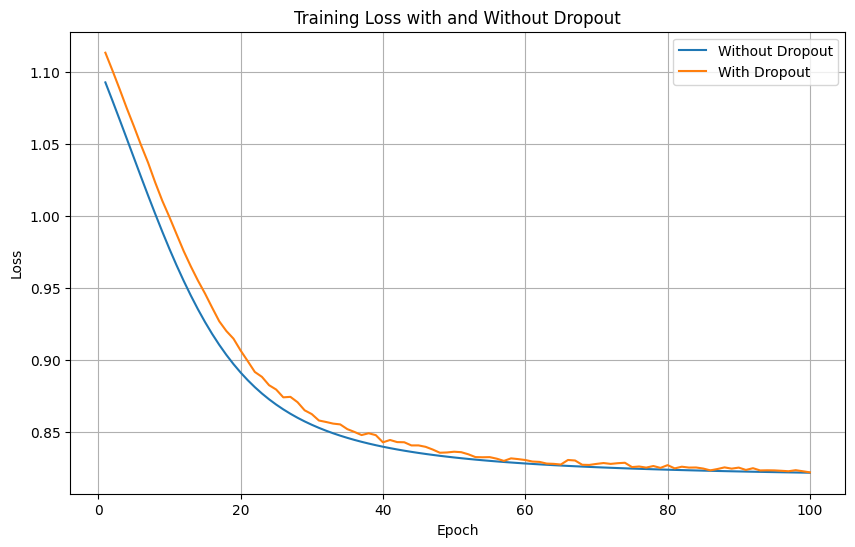

In [26]:
# Evaluate dropout model
bow_ff_nn_predictions_dropout = []
original_labels_ff_bow_dropout = []

ff_nn_bow_model_dropout.eval()
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_bow_vector(review_dict, row['stemmed_tokens'])
        probs = ff_nn_bow_model_dropout(bow_vec)
        bow_ff_nn_predictions_dropout.append(torch.argmax(probs, dim=1).cpu().numpy()[0])
        original_labels_ff_bow_dropout.append(make_target(Y_test[index]).cpu().numpy()[0])

print("Classification Report with Dropout:")
print(classification_report(original_labels_ff_bow_dropout, bow_ff_nn_predictions_dropout))

# Plot comparison of losses
ffnn_loss_df = pd.read_csv(ffnn_loss_file_name)
ffnn_loss_df_dropout = pd.read_csv(ffnn_loss_file_name_dropout)

plt.figure(figsize=(10,6))
plt.plot(ffnn_loss_df['iter'], ffnn_loss_df[' loss'], label='Without Dropout')
plt.plot(ffnn_loss_df_dropout['iter'], ffnn_loss_df_dropout[' loss'], label='With Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with and Without Dropout')
plt.legend()
plt.grid(True)
plt.show()
